# Plotting Tracers on Horizontal Planes (Depth Slices)

This notebook contains discussion, examples, and best practices for plotting tracer variable (e.g. temperature, salinity, sea surface height) results from NEMO as colour meshes. It extends the discussion of horizontal slice visualizations in the [Plotting Bathymetry Colour Meshes.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Plotting%20Bathymetry%20Colour%20Meshes) notebook with plotting of slices at selected depths and time steps of variables like temperature and salinity that are calculated on the 3D grid.
Topics include:

* Reading tracer variable values from NEMO `*grid_T.nc` results files
* Plotting sea surface height fields at selected times
* Approximate land areas masks for tracer field plots
* Using slices to zoom in on domain regions
* Plotting contour bands and lines
* Plotting temperature fields at selected depths
* Adding contour lines to colour mesh plots
* Anomaly plots
* Plotting salinity fields with various colour scales

As always,
we'll start with our imports,
and activation of the Matplotlib `inline` backend
so that our plots will appear below the cells that create them.

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import (
    nc_tools,
    viz_tools,
)

In [2]:
%matplotlib inline

## NEMO `grid_T` Results Files

In NEMO,
scalar quantities like temperature,
salinity, are referred to as tracers.
They and sea surface height (pressure) are stored at the tracer grid point locations of an
[Akawara C grid](http://clouds.eos.ubc.ca/~phil/numeric/labs/lab7/lab7.pdf#section.7)
which NEMO calls the T-grid.

The results files that contain the scalar values for a run have names like:
```bash
    SalishSea_1h_20021026_20021026_grid_T.nc
``` 
where:

* The `SalishSea` part comes from the "experience name" variable `cn_exp`
in the `&namrun` namelist
* The `1h` indicates both the time interval of the results in the file
and the time period over which the values are averaged.
In the example above the values are hourly averages that are reported hourly.
The time interval for a given run is specified in the `iodef.xml` file
that is used for the run.
* The date parts,
`20021026` twice in the example above,
are the start and end dates of the run.
* The `grid_T` part indicates that the file contains T-grid variable results.
The particular variables stored for a given run are specified in the `iodef.xml`
file that is used for the run.

So,
the results file above contains hourly averaged values of T-grid variables
for the single day run for 2002-10-26.

We'll use a results file from one of the spin-up runs that are stored in
the `/results/SalishSea/spin-up/2002/` directory.
Let's load the file into a netCDF dataset object and look at its dimensions:

In [3]:
tracers = nc.Dataset('/results/SalishSea/spin-up/2002/26oct/SalishSea_1h_20021026_20021026_grid_T.nc')

In [4]:
nc_tools.show_dimensions(tracers)

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 24

<class 'netCDF4._netCDF4.Dimension'>: name = 'tbnds', size = 2



As is the case for most NEMO results files,
the dataset has:

* The 2 lateral dimensions that are the same as those of the bathymetry file
(see the [Exploring netCDF Files.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Exploring%20netCDF%20Files.ipynb) notebook);
`x` and `y` with sizes 398 and 898,
respectively.
* A depth levels dimension that NEMO calls `deptht` with a size of 40.
* A time dimension that NEMO calls `time_counter`.
It is marked as unlimited meaning that it is the dimension along which the file
grows as NEMO calculates results.
Its size in this dataset is 24 because the file contains 1 day's hourly results.
* A time counter bounds dimension called `tbnds` with a size of 2 that provides
information about the time intervals in the `time_counter` dimension.

Now let's look at the variables in the dataset:

In [5]:
nc_tools.show_variables(tracers)

odict_keys(['nav_lon', 'nav_lat', 'deptht', 'time_counter', 'time_counter_bnds', 'sossheig', 'votemper', 'vosaline', 'rain_rate', 'snow_rate'])


The first 5 variables correspond to the dataset's dimensions:

* `nav_lon` and `nav_lat` contain the longitudes and latitudes of lateral grid points
(as we saw in the [Exploring netCDF Files.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Exploring%20netCDF%20Files.ipynb) notebook)
* `deptht` contains the depths of the vertical grid layers
* `time_counter` contains the model time values at the centre of each of the output intervals
* `time_counter_bnds` contains the start and end times of each of the intervals in `time_counter`

The remaining variables are calculated values from NEMO.
Their names come from NEMO's (sometimes cryptic) "doctor" naming scheme:

* `sossheig` is the sea surface height field which has 2 spatial dimensions
(`y` and `x`)
* `votemper` is the temperature field which has 3 spatial dimensions
(`y`, `x`, and `deptht`)
* `vosaline` is the salinity field with the same 3 spatial dimensions
* `rain_rate` is the liquid precipitation rate field (2 spatial dimensions)
* `snow_rate` is the solid precipitation rate field (also 2 spatial dimensions).
In the Salish Sea NEMO model all precipitation is constrained to be liquid,
so the `snow_rate` values are always zero.

Taking a deeper look at the attributes and values of the `time_counter` and `time_counter_bnds` variables:

In [6]:
nc_tools.show_variable_attrs(tracers, 'time_counter')
tracers.variables['time_counter'][:]

<class 'netCDF4._netCDF4.Variable'>
float64 time_counter(time_counter)
    axis: T
    standard_name: time
    units: seconds since 2002-10-26 00:00:00
    calendar: gregorian
    title: Time
    long_name: Time axis
    time_origin:  2002-OCT-26 00:00:00
    bounds: time_counter_bnds
unlimited dimensions: time_counter
current shape = (24,)
filling off



array([  1800.,   5400.,   9000.,  12600.,  16200.,  19800.,  23400.,
        27000.,  30600.,  34200.,  37800.,  41400.,  45000.,  48600.,
        52200.,  55800.,  59400.,  63000.,  66600.,  70200.,  73800.,
        77400.,  81000.,  84600.])

The time values are measured in seconds since the date/time at which
the run started,
in this case midnight UTC on 2002-10-26.
The values are the midpoints of the output intervals
(1 hour in this case) because the calculated variable values in the output
are averaged over the output interval.

Note that NEMO runs always start at midnight UTC on the date given in the
`&namrun` namelist.
It is coincidental that we are looking at a 2002-10-26 results file
from the first day of a series of spin-up runs;
spin-up runs for later dates also count time from midnight UTC on 2002-10-26,
not from the beginning of the run period.

In [7]:
nc_tools.show_variable_attrs(tracers, 'time_counter_bnds')
tracers.variables['time_counter_bnds'][:]

<class 'netCDF4._netCDF4.Variable'>
float64 time_counter_bnds(time_counter, tbnds)
unlimited dimensions: time_counter
current shape = (24, 2)
filling off



array([[     0.,   3600.],
       [  3600.,   7200.],
       [  7200.,  10800.],
       [ 10800.,  14400.],
       [ 14400.,  18000.],
       [ 18000.,  21600.],
       [ 21600.,  25200.],
       [ 25200.,  28800.],
       [ 28800.,  32400.],
       [ 32400.,  36000.],
       [ 36000.,  39600.],
       [ 39600.,  43200.],
       [ 43200.,  46800.],
       [ 46800.,  50400.],
       [ 50400.,  54000.],
       [ 54000.,  57600.],
       [ 57600.,  61200.],
       [ 61200.,  64800.],
       [ 64800.,  68400.],
       [ 68400.,  72000.],
       [ 72000.,  75600.],
       [ 75600.,  79200.],
       [ 79200.,  82800.],
       [ 82800.,  86400.]])

The `time_counter_bnds` values are the start and end times of the output intervals.
Although the variable attributes don't say so,
it is evident that the values have the same units as the time values:
seconds since midnight UTC on 2002-10-26.

We're going to use the `time_counter` variable values below to label plots,
so let's alias it as `timesteps`:

In [8]:
timesteps = tracers.variables['time_counter']

## Plotting Sea Surface Height Fields and Time Slicing

Looking at the attributes of the `sossheig` variable:

In [9]:
nc_tools.show_variable_attrs(tracers, 'sossheig')

<class 'netCDF4._netCDF4.Variable'>
float32 sossheig(time_counter, y, x)
    units: m
    standard_name: sea surface height
    _FillValue: 9.96921e+36
    long_name: sea surface height
    online_operation: ave(X)
    interval_operation: 10.0
    interval_write: 3600.0
    coordinates: time_counter nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (24, 898, 398)
filling off



`sossheig` is a 3-dimensional array.
Its axes,
`(time_counter, y, x)`,
reflect the netCDF CF1.6 conventional ordering,
`(t, z, y, x)`,
with `z` excluded because there are not depth values.
In particular,
netCDF requires that the unlimited dimension be the leftmost one.

The shape is `(24, 898, 398)`;
i.e. 24 hours,
898 y-direction values,
and 398 x-direction values.

The `units`,
`standard_name`,
and `long_name` attributes are self-explatory.

`online_operation: ave(X)` tells us that the values are averaged
over the output interval.
`interval_write: 3600.0` tells us that the output interval is
3600 s = 1 hr.
`interval_operation: 10.0` tells us that the time step for the 
calculation of the values that are averaged is 10 s.

The `_FillValue: 9.96921e+36` and `filling off` attribute values are clues
that the sea surface height values are not masked
(as we will see in a moment in a plot).
In constrast to the bathymetry data file which contains metadata to
automatically mask out land areas,
we have to explicitly create land masks for NEMO output variables.

Let's alias that variable as `ssh` to save on keystrokes:

In [10]:
ssh = tracers.variables['sossheig']

We can obtain the sea surface height field over the entire domain
at a given time step by slicing on the first axis
(remember that Python uses zero-based indexing):

In [11]:
print(ssh[0].shape)
ssh[0]

(898, 398)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

We can also slice on the 2nd and 3rd axes to obtain the field values
over part of the domain:

In [12]:
ssh_part = ssh[5, 250:325, 100:150]
print(ssh_part.shape)
ssh_part

(75, 50)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-1.32869375, -1.324965  , -1.32320511, ...,  0.        ,
         0.        ,  0.        ],
       [-1.32933927, -1.32603157, -1.32355893, ...,  0.        ,
         0.        ,  0.        ],
       [-1.32961977, -1.32633412, -1.32388937, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

Plot a colour mesh of ssh at the first time step:

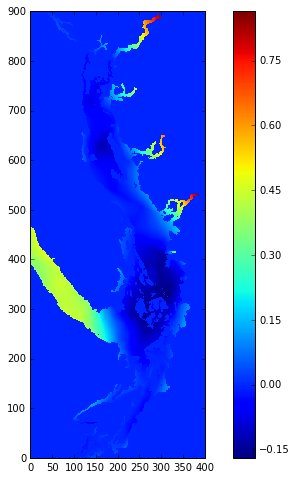

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(ssh[0])
fig.colorbar(mesh)

As noted above,
the values in NEMO results files are generally not masked like
our bathymetry data.
The land areas have zero as their value.

### Adding an Approximate Land Mask

We can quickly create an approximate land mask for tracer variables
by creating a
[NumPy Masked Array](http://docs.scipy.org/doc/numpy/reference/maskedarray.html)
object with the zero values masked:

In [14]:
ssh0 = np.ma.masked_values(ssh[0], 0)

Note,
however,
that creating the land mask that way will create land-like artifacts
at grid points where the sea surface height happens to be
within `np.ma.masked_values()`'s default absolute tolerance ($10^{-8}$) of zero.
To be rigourously accurate for things like publication plots the land mask from
the bathymetry data should be used.

That said,
the quick land mask is adequate for most purposes
and certainly improves the appearance of our plot:

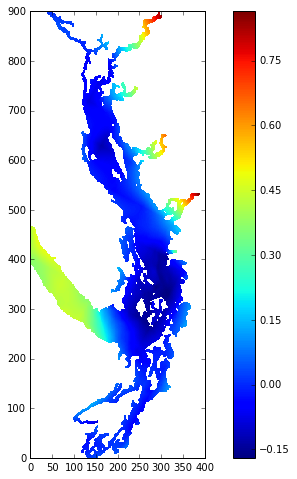

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(ssh0)
fig.colorbar(mesh)

We can use the same plotting techniques that we used for bathymetry in the
[Plotting Bathymetry Colour Meshes.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Plotting%20Bathymetry%20Colour%20Meshes.ipynb)
notebook to set a colour for the land mask,
tune the axes limits to remove white bands at the left and top edges,
and add titles to the axes:

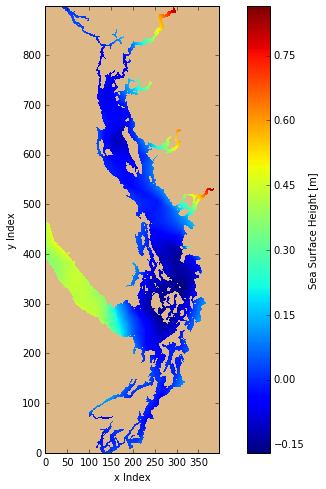

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(ssh0, cmap=cmap)
cbar = fig.colorbar(mesh)
plt.axis((0, ssh0.shape[1], 0, ssh0.shape[0]))

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
cbar.set_label('{label} [{units}]'.format(label=ssh.long_name.title(), units=ssh.units))

Plotting the results from several time steps side by side takes just a little bit more work
with the help of a couple of argument changes in `plt.subplots()`,
a loop,
and the Python built-in function `zip()`:

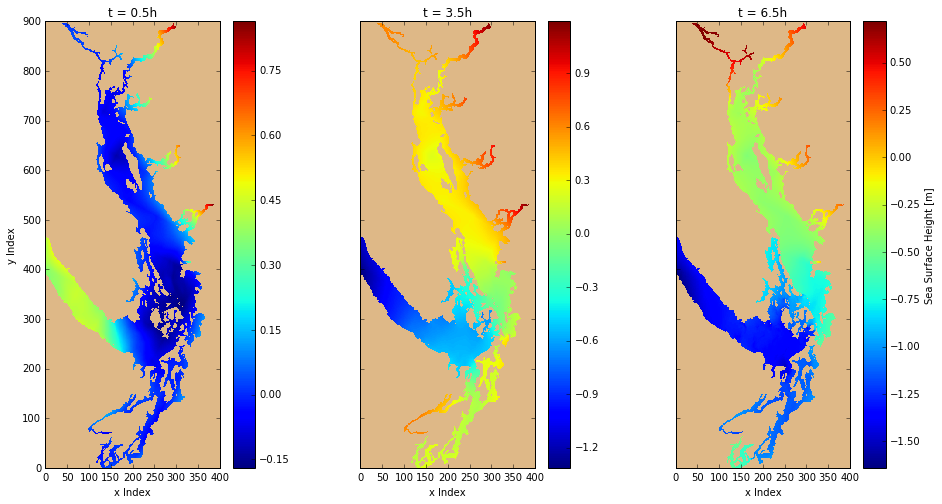

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
    
time_steps = (0, 3, 6)
for ax, t in zip(axs, time_steps):
    ssh_t = np.ma.masked_equal(ssh[t], 0)
    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(ssh_t, cmap=cmap)
    cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title('t = {:.1f}h'.format(timesteps[t] / 3600))
    ax.set_xlabel('x Index')
    
axs[0].set_ylabel('y Index')
cbar.set_label('{label} [{units}]'.format(label=ssh.long_name.title(), units=ssh.units))

Things to note in the above code cell:

* We're using the `time_counter` variable from the tracers dataset calculate
the time in hours for the plot axes titles
* The first 2 arguments to `plt.subplots()` specify the number of rows and columns
of axes objects to create within the figure object.
The axes objects are returned as a tuple,
`axs` in the code above.
* We increased the figure size to make room for the 3 axes and to give them enough
space between to look good.
* The `sharey=True` argument to `plt.subplots()` causes all of the axes to have the
same y-axis scale and suppresses the y-axis labels on all but the leftmost axes object.
* `zip()` returns,
one at a time,
tuples composed of the elements of the iterables given to it as arguments,
in this case,
the tuple of axes objects,
`axs`,
and the tuple of time step indices,
`time_steps`.
That allows us to associate each time step index with axes object in sequence,
left to right.
* The `ax=ax` argument to `fig.colorbar()` is used to indicate with axes object
in the figure the colour bar should be created for.
* The y-axis label is set on the leftmost axes object,
`axs[0]`.
* We take advantage of the fact that the value of `cbar` at the end of the loop
is the rightmost colour bar and set its title after the loop has finished.

Once we've looked at the resulting set of plots we can use the `vmin` and `vmax` argument to
`ax.colormesh()` to set the colour bar limits so that they are the same on all 3 plots
and so that they encompass the sea surface height range of all 3:

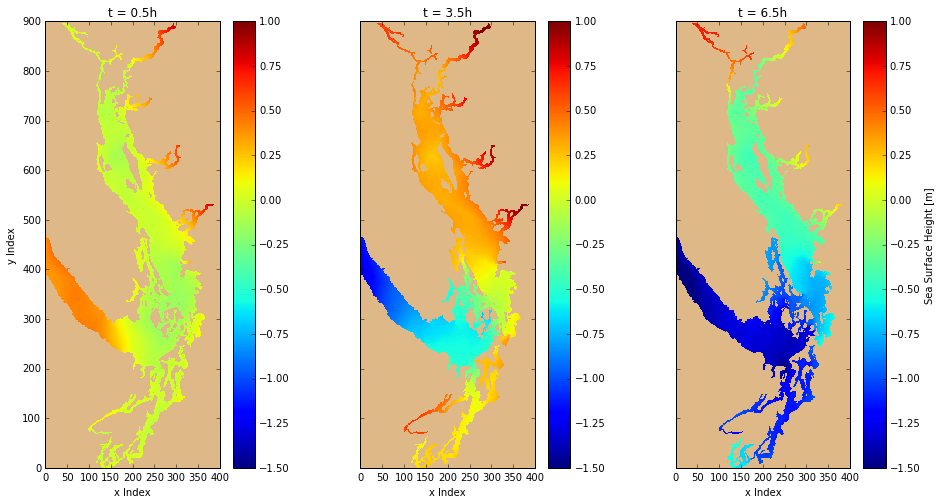

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
    
time_steps = (0, 3, 6)
for ax, t in zip(axs, time_steps):
    ssh_t = np.ma.masked_equal(ssh[t], 0)
    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(ssh_t, cmap=cmap, vmin=-1.5, vmax=1)
    cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title('t = {:.1f}h'.format(timesteps[t] / 3600))
    ax.set_xlabel('x Index')
    
axs[0].set_ylabel('y Index')
cbar.set_label('{label} [{units}]'.format(label=ssh.long_name.title(), units=ssh.units))

## Zooming by Slicing

In the
[Plotting Bathymetry Colour Meshes.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Plotting%20Bathymetry%20Colour%20Meshes.ipynb)
notebook we used the `plt.axis()` method to zoom in on a region of the domain.
An alternative that is faster is to use slices on the `y` and `x` dimensions
to plot the region of interest.
That's faster because the `plt.axis()` technique comes only after a colour mesh
has been calculated and then applies a display window to it.
Using slices means that the colour mesh only has to be calculated for the region
of interest.
We could still use `plt.axis()` to tune the axes limits,
or they can be set via a method call on the axes object,
as can grid visibility.

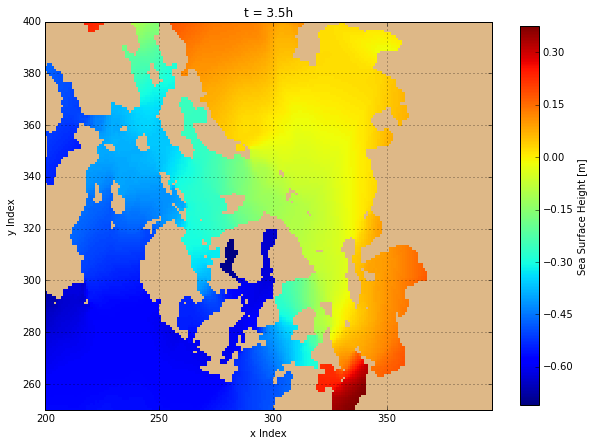

In [19]:
t = 3
y_slice = np.arange(250, 401)
x_slice = np.arange(200, 397)
ssh3_region = np.ma.masked_values(ssh[t, y_slice, x_slice], 0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_slice, y_slice, ssh3_region, cmap=cmap)
cbar = fig.colorbar(mesh, shrink=0.85)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
cbar.set_label('{label} [{units}]'.format(label=ssh.long_name.title(), units=ssh.units))
ax.set_title('t = {:.1f}h'.format(timesteps[t] / 3600))

## Plotting Contour Bands and Lines

The colour mesh field plots that we have created so far provide
a view of the values plotted in which the colours vary continuously
from one grid cell to the next.
Sometimes it is preferrable to plot the values in distinct colour bands,
especially if you are making quantitative assessments or comparisons.
To achieve that we switch from plotting pseudocolour meshes to
plotting contours,
both as filled polygons,
and as lines.

The `axes.contourf()` method creates filled polygons that we use
to produce our colour bar in the same way as we did with
the mesh collection returned by `axes.pcolormesh()`.
The `axes.contour()` method adds contour lines at the poylgon edges
and we add the collection of lines it returns to the colour bar
with the `cbar.add_lines()` method.

Finally,
we need to plot a contour line along the coastline to close the
contour polygons.
For that we need to use bathymetry data,
and the `viz_tools.plot_coastline()` function allows us to draw
the coastline on either grid or map coordinates.

In [20]:
help(viz_tools.plot_coastline)

Help on function plot_coastline in module salishsea_tools.viz_tools:

plot_coastline(axes, bathymetry, coords='grid', isobath=0, xslice=None, yslice=None, color='black')
    Plot the coastline contour line from bathymetry on the axes.
    
    The bathymetry data may be specified either as a file path/name,
    or as a :py:class:`netCDF4.Dataset` instance.
    If a file path/name is given it is opened and read into a
    :py:class:`netCDF4.Dataset` so,
    if this function is being called in a loop,
    it is best to provide it with a bathymetry dataset to avoid
    the overhead of repeated file reads.
    
    :arg axes: Axes instance to plot the coastline contour line on.
    :type axes: :py:class:`matplotlib.axes.Axes`
    
    :arg bathymetry: File path/name of a netCDF bathymetry data file
                     or a dataset object containing the bathymetry data.
    :type bathymetry: str or :py:class:`netCDF4.Dataset`
    
    :arg coords: Type of plot coordinates to set the aspect

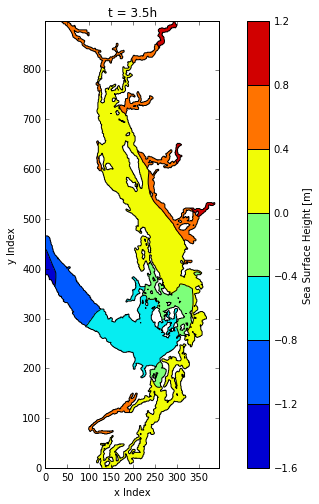

In [21]:
t = 3
ssh3 = np.ma.masked_values(ssh[t], 0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
contour_fills = ax.contourf(ssh3)
contour_lines = ax.contour(ssh3, colors='black', linestyles='solid')
viz_tools.plot_coastline(ax, '../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
cbar = fig.colorbar(contour_fills)
cbar.add_lines(contour_lines)

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
cbar.set_label('{label} [{units}]'.format(label=ssh.long_name.title(), units=ssh.units))
ax.set_title('t = {:.1f}h'.format(timesteps[t] / 3600))

With a few argument changes and additions we can plot contour bands
on map coordinates.
Note that `viz_tools.plot_coastline()` accepts either the file path/name
of a bathymetry data file,
or a `nc.Dataset` instance created from one.
Here we do the latter because we also need the bathymetry latitudes and longitudes
to pass into the contour plotting methods.

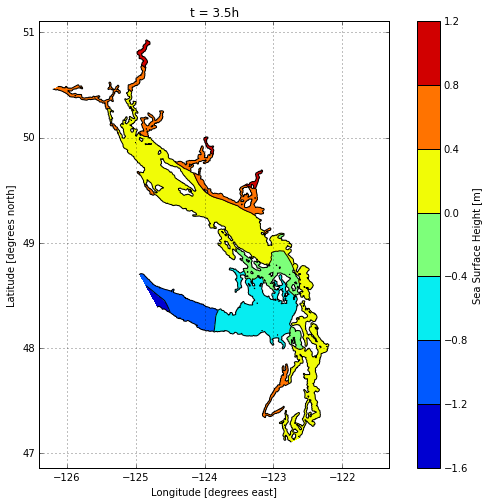

In [22]:
grid = nc.Dataset('../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid.variables['nav_lat']
lons = grid.variables['nav_lon']

t = 3
ssh3 = np.ma.masked_values(ssh[t], 0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax, coords='map', lats=lats)
contour_fills = ax.contourf(lons[:], lats[:], ssh3)
contour_lines = ax.contour(lons[:], lats[:], ssh3, colors='black', linestyles='solid')
viz_tools.plot_coastline(ax, grid, coords='map')
cbar = fig.colorbar(contour_fills)
cbar.add_lines(contour_lines)

ax.grid()
ax.set_xlabel('{longitude.long_name} [{longitude.units}]'.format(longitude=lons))
ax.set_ylabel('{latitude.long_name} [{latitude.units}]'.format(latitude=lats))
cbar.set_label('{label} [{units}]'.format(label=ssh.long_name.title(), units=ssh.units))
ax.set_title('t = {:.1f}h'.format(timesteps[t] / 3600))

##Plotting Temperature Field on Horizontal Planes

Now let's shift our attention to the temperature field:

In [23]:
nc_tools.show_variable_attrs(tracers, 'votemper')

<class 'netCDF4._netCDF4.Variable'>
float32 votemper(time_counter, deptht, y, x)
    units: degC
    standard_name: temperature
    _FillValue: 9.96921e+36
    long_name: temperature
    online_operation: ave(X)
    interval_operation: 10.0
    interval_write: 3600.0
    coordinates: time_counter deptht nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (24, 40, 898, 398)
filling off



In contrast to sea surface height,
temperature results are 4-dimensional arrays with the axes ordered `(t, z, y, x)`.
The `z` dimension is positive downward
(i.e. depth increases with increasing z-index values)
as indicated by the `positive: down` attribute of the `deptht` variable;

In [24]:
nc_tools.show_variable_attrs(tracers, 'deptht')

<class 'netCDF4._netCDF4.Variable'>
float32 deptht(deptht)
    axis: Z
    standard_name: model_level_number
    units: m
    positive: down
    valid_min: 0.5
    valid_max: 441.466
    title: deptht
    long_name: Vertical T levels
unlimited dimensions: 
current shape = (40,)
filling off



The `deptht` variable values are the nominal midpoints of the model depth layers:

In [25]:
tracers.variables['deptht'][:]

array([   0.5000003 ,    1.5000031 ,    2.50001144,    3.50003052,
          4.50007057,    5.50015068,    6.50031042,    7.50062323,
          8.50123596,    9.50243282,   10.50476551,   11.50931168,
         12.51816654,   13.53541183,   14.56898212,   15.63428783,
         16.76117325,   18.00713539,   19.48178482,   21.38997841,
         24.10025597,   28.22991562,   34.68575668,   44.51772308,
         58.48433304,   76.58558655,   98.06295776,  121.86651611,
        147.08946228,  173.11448669,  199.57304382,  226.26029968,
        253.06663513,  279.93453979,  306.834198  ,  333.75018311,
        360.67453003,  387.60321045,  414.53408813,  441.46609497], dtype=float32)

Note that layers are approximately 1 m thick near the surface,
but increase in thickness with depth.
Furthermore,
the model uses partial z-steps at depth,
and it adjusts the surface layers in response to changes in sea surface level.
So,
the precise layer thicknesses and midpoint depths vary both temporally and spatially.

Aliasing the temperature and depth layer midpoint variables to save on keystrokes:

In [26]:
temper = tracers.variables['votemper']
zlevels = tracers.variables['deptht']

As with sea surface height,
we access the temperature field values using slices,
but now we have 4 axes to deal with rather than 3.
So:

* The surface layer (0 to ~1m) temperature field at the 3rd time step is `temper[2, 0]`
* The ~10.5m temperature field at time step zero is `temper[0, 10]`
* The ~2.5m temperature field at the last time step
in a region that includes some of the Fraser River plume is:

In [27]:
temper[-1, 2, 400:450, 275:325]

array([[ 10.89370728,  10.89942741,  10.91184521, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.87751865,  10.88292503,  10.89572525, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.86694431,  10.87142372,  10.8831234 , ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [ 10.40889263,  10.3713665 ,  10.33268642, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.42024708,  10.38743591,  10.35234833, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.42642498,  10.40050793,  10.37171364, ...,   0.        ,
          0.        ,   0.        ]], dtype=float32)

Apart from handling the presence of the z-axis dimension,
plotting colour meshes of temperature field is very similar to
what we have already done for sea surface height:

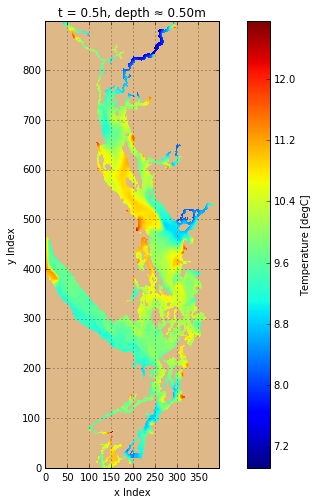

In [28]:
t, zlevel = 0, 0
temper_tz = np.ma.masked_values(temper[t, zlevel], 0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(temper_tz, cmap=cmap)
cbar = fig.colorbar(mesh)
plt.axis((0, temper_tz.shape[1], 0, temper_tz.shape[0]))

ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
cbar.set_label('{label} [{units}]'.format(label=temper.long_name.title(), units=temper.units))
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

Creating masked arrays
(with the mask value set to zero)
from time and depth slices of the temperature array
allows us to create plots that show the land/water boundaries at depth.

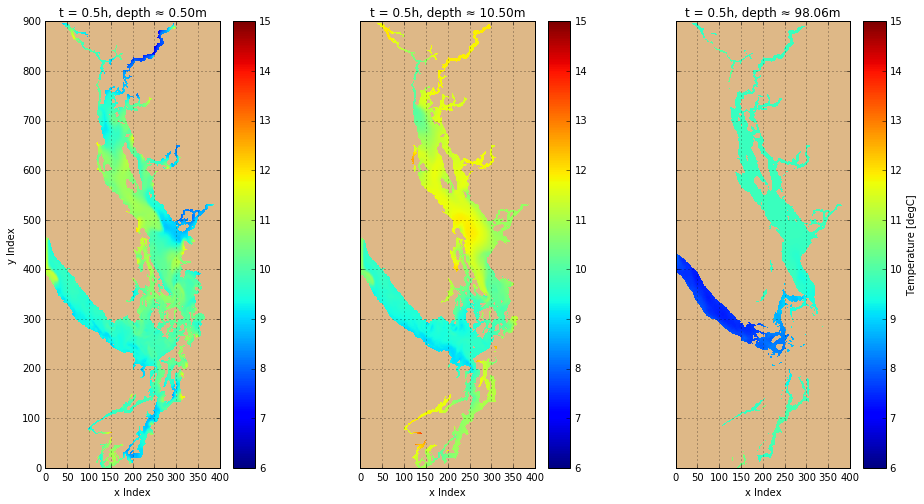

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
for ax in axs:
    viz_tools.set_aspect(ax)

cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')

t = 0
levels = (0, 10, 26)
for ax, z in zip(axs, levels):
    temper_tz = np.ma.masked_equal(temper[t, z], 0)
    mesh = ax.pcolormesh(temper_tz, cmap=cmap, vmin=6, vmax=15)
    cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[z], z=zlevels))
    ax.set_xlabel('x Index')
    ax.grid()
    
axs[0].set_ylabel('y Index')
cbar.set_label('{label} [{units}]'.format(label=temper.long_name.title(), units=temper.units))

## Adding Contour Lines to Colour Mesh Plots

Let's zoom in on an interesting looking area of the domain
and create a colour mesh plot with temperature contour lines
(isotherms):

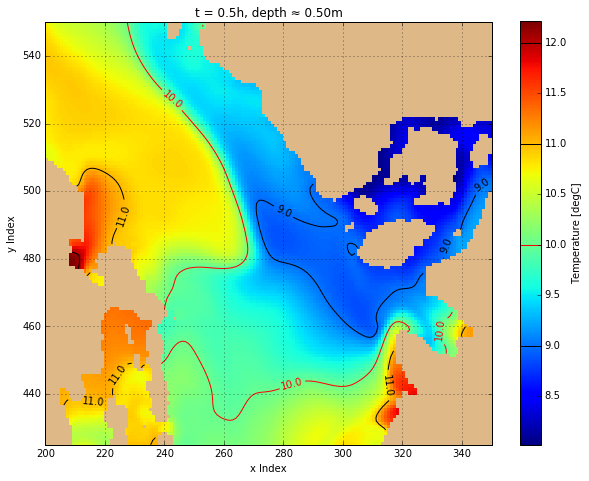

In [30]:
t, zlevel = 0, 0
y_slice = np.arange(425, 551)
x_slice = np.arange(200, 351)
temper_tz = np.ma.masked_values(temper[t, zlevel, y_slice, x_slice], 0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_slice, y_slice, temper_tz, cmap=cmap)
clines = ax.contour(
    x_slice, y_slice, temper_tz, np.arange(8, 13),
    colors=['black', 'black', 'red', 'black', 'black'])
ax.clabel(clines, fmt='%1.1f')
cbar = fig.colorbar(mesh, shrink=0.95)
cbar.add_lines(clines)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
cbar.set_label('{label} [{units}]'.format(label=temper.long_name.title(), units=temper.units))
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

## Anomaly Plots

It's often useful to plot a colour mesh of the differences in value
of a field variable between a pair of time steps or runs to help to
visualize changes over model time or changes due to alteration of
model parameters, forcing, code, etc.
As an example,
we'll plot the temperature field at 2 consecutive time steps
and the difference between them.
For the difference field we'll use a colour map that is white at zero
and increases in colour intensity for increasingly positive and negative values.

The `viz_tools.calc_abs_max()` function is useful to obtain the maximum
absolute value in an array which can be used to set the normalization limits
for the anomaly plots so that zero is in the centre of the colour range.

In [31]:
help(viz_tools.calc_abs_max)

Help on function calc_abs_max in module salishsea_tools.viz_tools:

calc_abs_max(array)
    Return the maximum absolute value in the array.
    
    :arg array: Array to find the maximum absolute value of.
    :type array: :py:class:`numpy.ndarray` or :py:class:`netCDF4.Dataset`
    
    :returns: Maximum absolute value
    :rtype: :py:class:`numpy.float32`



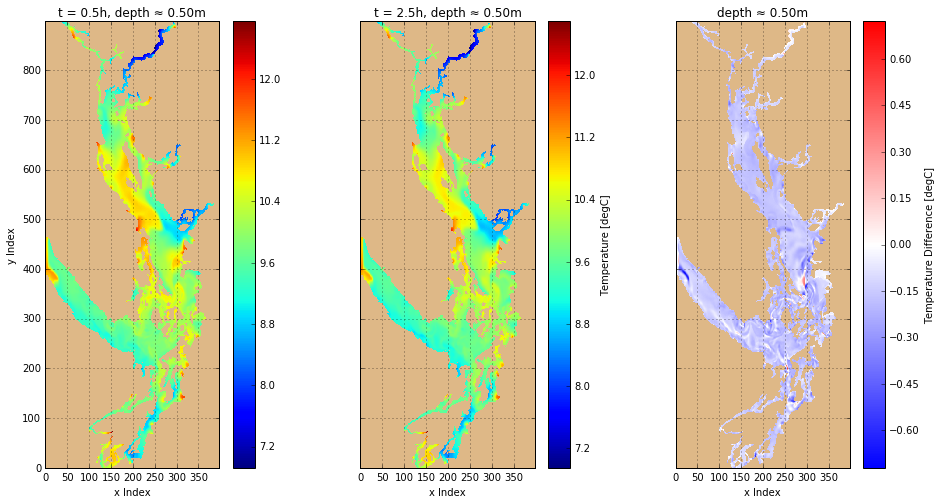

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
for ax in axs:
    viz_tools.set_aspect(ax)
    
cmap = plt.get_cmap('jet')
anomaly_cmap = plt.get_cmap('bwr')
for c in (cmap, anomaly_cmap):
    c.set_bad('burlywood')

time_steps = (0, 2)
z = 0

# Temperature fields at the time steps
for ax, t in zip(axs[:2], time_steps):
    temper_tz = np.ma.masked_values(temper[t, z], 0)
    mesh = ax.pcolormesh(temper_tz, cmap=cmap)
    cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[z], z=zlevels))
    ax.set_xlabel('x Index')
    ax.set_xlim(0, temper_tz.shape[1])
    ax.set_ylim(0, temper_tz.shape[0])
    ax.grid()
axs[0].set_ylabel('y Index')
cbar.set_label('{label} [{units}]'.format(label=temper.long_name.title(), units=temper.units))

# Temperature field difference between the time steps
ax = axs[2]
temper_diff = temper[time_steps[1], z] - temper[time_steps[0], z]
temper_diff = np.ma.masked_values(temper_diff, 0, copy=False)
abs_max = viz_tools.calc_abs_max(temper_diff)
mesh = ax.pcolormesh(temper_diff, cmap=anomaly_cmap, vmin=-abs_max, vmax=abs_max)
cbar = fig.colorbar(mesh, ax=ax)
ax.set_title(u'depth \u2248 {d:.2f}{z.units}'.format(d=zlevels[z], z=zlevels))
ax.set_xlabel('x Index')
ax.set_xlim(0, temper_diff.shape[1])
ax.set_ylim(0, temper_diff.shape[0])
ax.grid()
cbar.set_label('{label} Difference [{units}]'.format(label=temper.long_name.title(), units=temper.units))

## Plotting Salinity Fields

Finally,
we turn our attention to salinity field results:

In [33]:
nc_tools.show_variable_attrs(tracers, 'vosaline')

<class 'netCDF4._netCDF4.Variable'>
float32 vosaline(time_counter, deptht, y, x)
    units: psu
    standard_name: salinity
    _FillValue: 9.96921e+36
    long_name: salinity
    online_operation: ave(X)
    interval_operation: 10.0
    interval_write: 3600.0
    coordinates: time_counter deptht nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (24, 40, 898, 398)
filling off



Like temperature,
salinity results are 4-dimensional arrays.
Sadly,
NEMO continues the incorrect practice of declaring the units of
practical salinity values to be `psu`.
So,
we will not be able to use the `vosaline` variable attributes to label
our plots.
Instead, we will explicit use `Practical Salinity`.

In [34]:
sal = tracers.variables['vosaline']

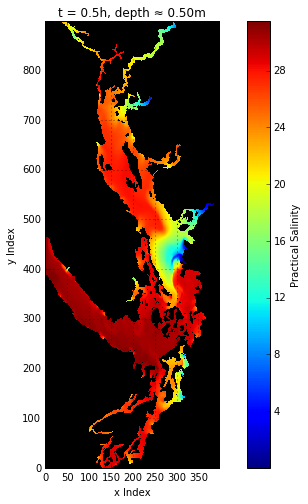

In [35]:
t, zlevel = 0, 0
sal_tz = np.ma.masked_values(sal[t, zlevel], 0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
cmap = plt.get_cmap('jet')
cmap.set_bad('black')
mesh = ax.pcolormesh(sal_tz, cmap=cmap)
cbar = fig.colorbar(mesh)
plt.axis((0, sal_tz.shape[1], 0, sal_tz.shape[0]))

ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
cbar.set_label('Practical Salinity')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

Many choices are possible for the colour map,
its normalization limits,
and the land mask colour.
Here 3 examples:

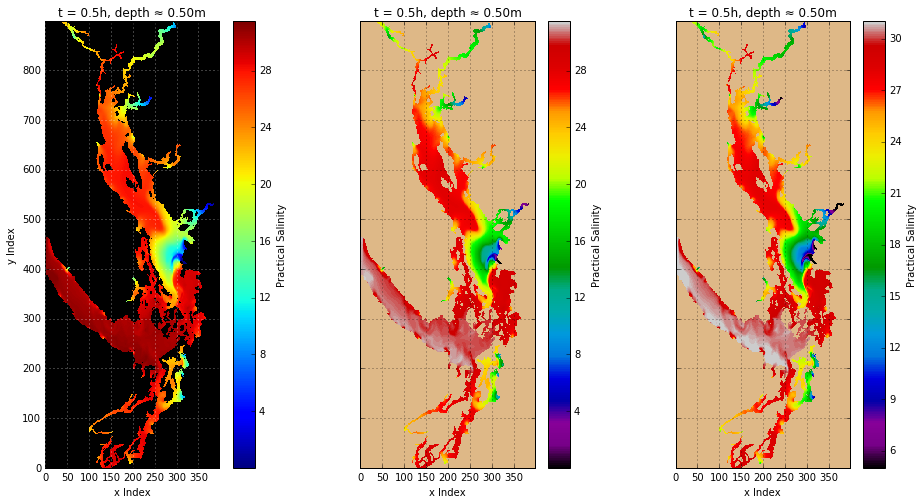

In [36]:
t, zlevel = 0, 0
sal_tz = np.ma.masked_values(sal[t, zlevel], 0)

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
for ax in axs:
    viz_tools.set_aspect(ax)
    ax.set_xlabel('x Index')
    
axs[0].set_ylabel('y Index')

ax = axs[0]
cmap = plt.get_cmap('jet')
cmap.set_bad('black')
mesh = ax.pcolormesh(sal_tz, cmap=cmap)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity')
ax.set_xlim(0, sal_tz.shape[1])
ax.set_ylim(0, sal_tz.shape[0])
ax.grid(color='white')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

ax = axs[1]
cmap1 = plt.get_cmap('spectral')
cmap1.set_bad('burlywood')
mesh = ax.pcolormesh(sal_tz, cmap=cmap1)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity')
ax.set_xlim(0, sal_tz.shape[1])
ax.set_ylim(0, sal_tz.shape[0])
ax.grid()
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

ax = axs[2]
mesh = ax.pcolormesh(sal_tz, cmap=cmap1, vmin=5, vmax=31)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity')
ax.set_xlim(0, sal_tz.shape[1])
ax.set_ylim(0, sal_tz.shape[0])
ax.grid()
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=timesteps[t] / 3600, d=zlevels[zlevel], z=zlevels))

You need to experiment with combinations to find ones that allow you to
best visualize the features of most interest in a particular plot.
It is also important to keep in mind the purpose of the plot.
For instance,
`jet` and `spectral` may be poor choices for colourblind viewers.
They also loose most of their detail if they are converted to grayscale
by photocopying or printing on a monochrome printer.
In both cases colour maps that depend more on variations in saturation
rather than hue may be more appropriate.
See the [Matplotlib colour map gallery](http://matplotlib.org/examples/color/colormaps_reference.html)
for all of the built-in colour maps.

Changing the normalization limits affects how the data range is distributed across
the colour map range and can be used to emphasize different aspects of the flow.